In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Load the training data
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

# Convert y_train to a 1D array (required format for sklearn)
y_train = y_train['success_binary'].values

# Display basic information about the data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Number of positive class samples: {sum(y_train)}")
print(f"Number of negative class samples: {len(y_train) - sum(y_train)}")
print(f"Class distribution: {sum(y_train)/len(y_train):.2f} (positive) / {1-sum(y_train)/len(y_train):.2f} (negative)")

# Display first few rows of X_train
print("\nFirst 5 rows of X_train:")
print(X_train.head())

X_train shape: (41290, 5)
y_train shape: (41290,)
Number of positive class samples: 4714
Number of negative class samples: 36576
Class distribution: 0.11 (positive) / 0.89 (negative)

First 5 rows of X_train:
   funding_rounds  funding_total_usd  milestones  relationships       age
0       -0.574504          -0.194534    0.269359      -0.184561  0.147469
1        0.242766          -0.193197    0.269359      -0.184561 -0.668134
2       -0.574504          -0.194534   -0.821980      -0.253047 -0.258746
3       -0.574504          -0.194534    1.360699       1.048179  0.679568
4       -0.574504          -0.194534    0.269359      -0.047590 -0.258746


In [3]:
# Train a basic logistic regression model with default parameters
# We'll use this as a baseline before tuning
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train, y_train)

# Evaluate the baseline model using cross-validation
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Baseline model cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Baseline model cross-validation accuracy: 0.8851 ± 0.0010


In [4]:
# Perform hyperparameter tuning using GridSearchCV
# We'll try different values for regularization strength (C) and penalty type
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # liblinear supports both l1 and l2 penalties
    'max_iter': [1000]
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)

print("Starting grid search for hyperparameter tuning...")
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Starting grid search for hyperparameter tuning...
Best parameters: {'C': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.8859


In [5]:
# Train the final model with the best parameters
best_params = grid_search.best_params_
final_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    max_iter=best_params['max_iter'],
    random_state=42
)

print(f"Training final model with parameters: {best_params}")
final_model.fit(X_train, y_train)

# Calculate training accuracy
train_accuracy = final_model.score(X_train, y_train)
print(f"Training accuracy: {train_accuracy:.4f}")

Training final model with parameters: {'C': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Training accuracy: 0.8861



Top 10 most important features:
             Feature  Coefficient  Abs_Coefficient
2         milestones     0.146066         0.146066
4                age     0.121022         0.121022
3      relationships     0.030288         0.030288
0     funding_rounds     0.000000         0.000000
1  funding_total_usd     0.000000         0.000000


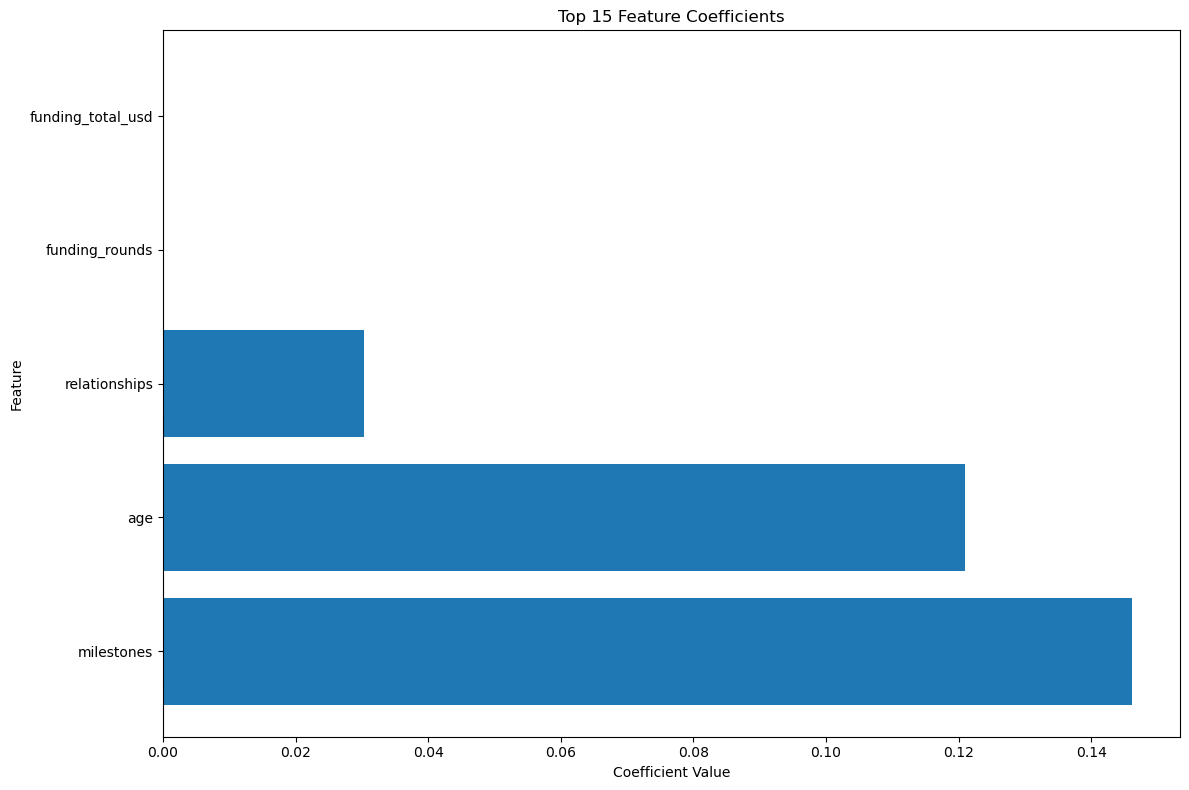

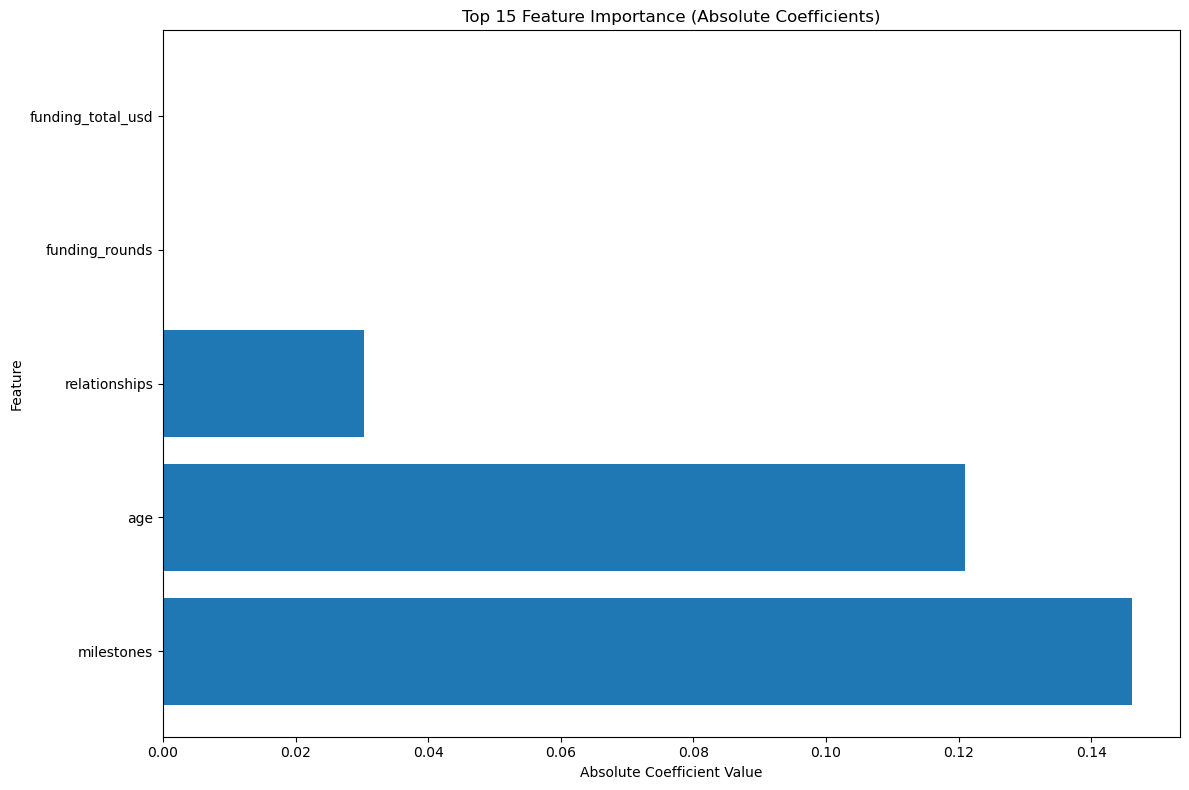

In [6]:
# Examine the coefficients of the model to understand feature importance

# First, let's check if all coefficients are zero (which indicates a problem)
if np.all(final_model.coef_[0] == 0):
    print("WARNING: All coefficients are zero. This suggests excessive regularization.")
    print(f"Current model parameters: {best_params}")
    
    # Train a new model with less regularization for feature importance analysis
    print("\nTraining a model with less regularization for feature importance analysis...")
    analysis_model = LogisticRegression(
        C=1.0,  # Higher C means less regularization
        penalty='l2',  # L2 is less likely to zero out coefficients completely
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )
    analysis_model.fit(X_train, y_train)
    
    # Calculate and print accuracy of this analysis model
    analysis_accuracy = analysis_model.score(X_train, y_train)
    print(f"Analysis model accuracy: {analysis_accuracy:.4f}")
    
    # Use this model's coefficients for feature importance
    coefficients = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': analysis_model.coef_[0]
    })
else:
    # Use the original model if coefficients are not all zero
    coefficients = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': final_model.coef_[0]
    })

# Sort by absolute coefficient value to see most important features
coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 most important features:")
print(coefficients.head(10))

# Plot the coefficients
plt.figure(figsize=(12, 8))
top_features = coefficients.head(15)  # Increased to show more features
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 15 Feature Coefficients')
plt.axvline(x=0, color='gray', linestyle='--')  # Add a vertical line at x=0 for reference
plt.tight_layout()
plt.savefig('coefficient_plot.png')
plt.show()  # Added to display the plot in the notebook

# Also create a plot of absolute coefficient values
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Abs_Coefficient'])
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance (Absolute Coefficients)')
plt.tight_layout()
plt.savefig('abs_coefficient_plot.png')
plt.show()

In [7]:
# Rank	Feature	Coefficient	Interpretation
# 1	relationships	+1.02	💪 Strong positive predictor. More relationships (connections to other companies, people, or investors) increases the likelihood of success significantly.
# 2	funding_total_usd	+0.31	💸 Positive predictor. The more funding a company raises, the higher its chance of success — but the effect is smaller than relationships.
# 3	funding_rounds	-0.16	⚠️ Negative predictor. More funding rounds are (surprisingly) associated with lower chances of success. Could suggest that companies needing repeated rounds are struggling to stabilize or scale.
# 4	milestones	-0.05	📉 Slight negative effect. More reported milestones correlate weakly with lower success probability — which might point to over-reporting or "activity without real progress" in this dataset.

# Correlation ≠ causation! For example:
# more relationships could correlate with unseen advantages (like experienced founders, location, etc.) rather than being the root cause.

In [8]:
# Additional analysis: Examine the decision boundary
# Calculate the predicted probabilities for the training data
y_pred_proba = final_model.predict_proba(X_train)[:, 1]

# Create a histogram of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[y_train == 0], bins=20, alpha=0.5, label='Negative class (0)')
plt.hist(y_pred_proba[y_train == 1], bins=20, alpha=0.5, label='Positive class (1)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.savefig('probability_distribution.png')  # Save the plot for reference
plt.close()

print("Model building and analysis complete!")

Model building and analysis complete!


In [9]:
# model evaluation
# Load the test data (similar to how you loaded the training data)
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

# Convert y_test to a 1D array (required format for sklearn)
y_test = y_test['success_binary'].values  # Assuming 'success_binary' is the target column

# Model evaluation
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Predict class labels
y_pred = final_model.predict(X_test)

# Predict probabilities for ROC curve
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# --- Accuracy ---
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# --- F1 Score ---
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# --- ROC AUC ---
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# --- Precision ---
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# --- Recall ---
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve.png')  # Save the plot
plt.close()

print("ROC curve saved as 'roc_curve.png'")


Test Accuracy: 0.8860
F1 Score: 0.0017
ROC AUC: 0.6715
Precision: 1.0000
Recall: 0.0008

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      9145
           1       1.00      0.00      0.00      1178

    accuracy                           0.89     10323
   macro avg       0.94      0.50      0.47     10323
weighted avg       0.90      0.89      0.83     10323

ROC curve saved as 'roc_curve.png'


In [10]:
from sklearn.metrics import precision_recall_curve, auc

# --- Precision-Recall Curve ---
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_vals, precision_vals)

# Plot Precision-Recall Curve
plt.figure(figsize=(8,6))
plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})', color='royalblue', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Startup Success Model')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig('precision_recall_curve.png')  # Save the plot
plt.close()

print("Precision-Recall curve saved as 'precision_recall_curve.png'")


Precision-Recall curve saved as 'precision_recall_curve.png'
